In [45]:
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_excel("dataset.xlsx", sheet_name=None, header=0)

In [47]:
all_df = {}
for i, d in enumerate(df.items()):
    name, data = d
    all_df[name] = data

In [48]:
data = all_df['1K-01']
data_test = all_df['1X-02']

In [49]:
data = data[data['DEPTH'] == data["DEPTH"]]   # drop NaN value row
data_test = data_test[data_test['DEPTH'] == data_test["DEPTH"]]   # drop NaN value row

In [50]:
data = data.drop(["Core_Facies"], axis=1)
data_test = data_test.drop(["Core_Facies"], axis=1)

In [51]:
comb = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
def label_facies(row):
    f = row['Fluid']
    lf = row['Log_Facies']
    return comb.index((f, lf)) + 1
data['MixLabel'] = data.apply(label_facies, axis=1)
data_test['MixLabel'] = data_test.apply(label_facies, axis=1)

In [52]:
X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
ss = StandardScaler()
X = ss.fit_transform(X)
X_o = X
X_test =  data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
X_test_o = ss.transform(X_test)

In [53]:
data['Log_Facies'] = data['Log_Facies'].apply(lambda x: int(x))
data_test['Log_Facies'] = data_test['Log_Facies'].apply(lambda x: int(x))

In [54]:
data_test['Fluid'].value_counts()

2    848
1    246
Name: Fluid, dtype: int64

In [55]:
data['Fluid'].value_counts()

2    704
1    321
Name: Fluid, dtype: int64

In [56]:
Y1 = np.copy(data['Log_Facies'].values)
Y2 =  np.copy( data['Fluid'].values)
Y3 =  np.copy(data['MixLabel'].values)

Y1 -= 1
Y2 -= 1
Y3 -= 1

ALL_Y = [Y2, Y1, Y3]

In [57]:
ALL_Y

[array([0, 0, 0, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 4, 4, 4])]

In [58]:
Y2_test =  np.copy(data_test['Fluid'].values)
Y2_test

array([1, 1, 1, ..., 2, 2, 2])

In [59]:
Y1_test =  np.copy(data_test['Log_Facies'].values)
Y2_test =  np.copy(data_test['Fluid'].values)
Y3_test =  np.copy(data_test['MixLabel'].values)

Y1_test -= 1
Y2_test -= 1
Y3_test -= 1


ALL_Y_TEST = [Y2_test, Y1_test, Y3_test]

In [60]:
ALL_Y_TEST

[array([0, 0, 0, ..., 1, 1, 1]),
 array([2, 2, 2, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 3, 3, 3])]

In [61]:
ALL_Y_TEST = [Y2_test, Y1_test, Y3_test]

## LogisticRegression

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
for (seq, label) in enumerate(['Fluid', 'Log_Facies', 'MixLabel']):
    Y = ALL_Y[seq]
    Y_TEST = ALL_Y_TEST[seq]
    clf = LogisticRegression()
    clf.fit(X_o, Y)
    pred = clf.predict(X_test_o)
    correct = pred[pred==Y_TEST].shape[0]
    print("label: {} correct: {:.2f}".format(label, correct/pred.shape[0]), correct)

label: Fluid correct: 0.88 960
label: Log_Facies correct: 0.77 838
label: MixLabel correct: 0.75 818


## Improved

In [68]:
current = -20
r = [current]
while current < 20:
    current+=0.5
    r.append(current)
def multi_power_only_one(power, y_index=0):
    X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]

    X_np_square = X_np ** power
    X_np_square = X_np_square[:,1:]
    a.append(X_np_square)
    X_all = np.hstack(a)
#     print(i, X_all.shape)
    ss = StandardScaler()
    X = ss.fit_transform(X_all)
    clf = LogisticRegression()
    Y = ALL_Y[y_index]
    clf.fit(X, Y)
    Y_pred = clf.predict(X)
    
    X = data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    
    X_np_square = X_np ** power
    X_np_square = X_np_square[:,1:]
    a.append(X_np_square)
    X_all = np.hstack(a)
    X = ss.fit_transform(X_all)
    Y_pred = clf.predict(X)
    Y_test = ALL_Y_TEST[y_index]
#     Y_pred[Y_pred==Y_test].shape[0]
    return Y_pred[Y_pred==Y_test].shape[0], power, clf, ss

In [72]:
result = [multi_power_only_one(i, 1) for i in r]

In [73]:
y = [i[0] for i in result]
x = [i[1] for i in result]

[799, 800, 802, 803, 802, 801, 801, 803, 803, 805, 805, 807, 807, 809, 810, 814, 814, 815, 817, 817, 818, 820, 820, 818, 821, 821, 820, 819, 816, 815, 816, 818, 819, 821, 824, 831, 828, 829, 831, 841, 794, 837, 788, 836, 838, 822, 818, 815, 818, 823, 816, 814, 810, 808, 807, 803, 803, 800, 799, 797, 794, 794, 792, 791, 789, 790, 789, 788, 788, 785, 781, 780, 780, 777, 774, 774, 771, 770, 769, 769, 767]
[-20, -19.5, -19.0, -18.5, -18.0, -17.5, -17.0, -16.5, -16.0, -15.5, -15.0, -14.5, -14.0, -13.5, -13.0, -12.5, -12.0, -11.5, -11.0, -10.5, -10.0, -9.5, -9.0, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0]


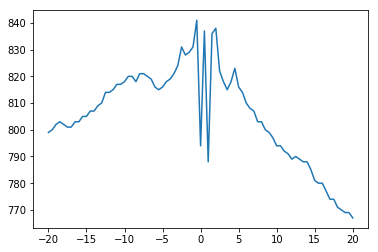

In [74]:
plt.plot(x, y)

In [85]:
current = -2.5
r_2 = [current]
while current < 2.5:
    current+=0.5
    r_2.append(current)
r_2.remove(0)
r_2.remove(1)
r_2
def multi_power_fixed(power,  y_index=0):
    X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
#     print(i, X_all.shape)
    ss = StandardScaler()
    X = ss.fit_transform(X_all)
    clf = LogisticRegression()
    Y = ALL_Y[y_index]
    clf.fit(X, Y)
    Y_pred = clf.predict(X)
    
    X = data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
    X = ss.fit_transform(X_all)
    Y_pred = clf.predict(X)
    Y_test = ALL_Y_TEST[y_index]
#     Y_pred[Y_pred==Y_test].shape[0]
    return Y_pred[Y_pred==Y_test].shape[0], Y_pred.shape[0]

In [86]:
correct, total = multi_power_fixed(None, 1)
print('LogFacies', correct, total, correct/total)

LogFacies 870 1094 0.7952468007312614


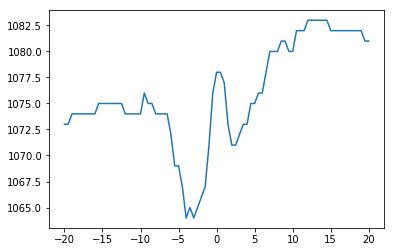

In [88]:
result = [multi_power_only_one(i, 0) for i in r]
y = [i[0] for i in result]
x = [i[1] for i in result]
plt.plot(x, y)

In [92]:
current = -2.5
r_2 = [current]
while current < 2.5:
    current+=0.5
    r_2.append(current)
r_2.remove(0)
r_2.remove(1)
r_2
def multi_power_fixed(power,  y_index=0):
    X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
#     print(i, X_all.shape)
    ss = StandardScaler()
    X = ss.fit_transform(X_all)
    clf = LogisticRegression()
    Y = ALL_Y[y_index]
    clf.fit(X, Y)
    Y_pred = clf.predict(X)
    
    X = data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
    X = ss.fit_transform(X_all)
    Y_pred = clf.predict(X)
    Y_test = ALL_Y_TEST[y_index]
#     Y_pred[Y_pred==Y_test].shape[0]
    return Y_pred[Y_pred==Y_test].shape[0], Y_pred.shape[0]

correct, total = multi_power_fixed(None, 0)
print('Fluid', correct, total, correct/total)

Fluid 1072 1094 0.979890310786106


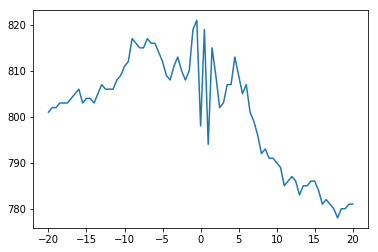

In [93]:
result = [multi_power_only_one(i, 2) for i in r]
y = [i[0] for i in result]
x = [i[1] for i in result]
plt.plot(x, y)

In [94]:
current = -2.5
r_2 = [current]
while current < 2.5:
    current+=0.5
    r_2.append(current)
r_2.remove(0)
r_2.remove(1)
r_2
def multi_power_fixed(power,  y_index=0):
    X = data[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
#     print(i, X_all.shape)
    ss = StandardScaler()
    X = ss.fit_transform(X_all)
    clf = LogisticRegression()
    Y = ALL_Y[y_index]
    clf.fit(X, Y)
    Y_pred = clf.predict(X)
    
    X = data_test[["DEPTH", "CALI", "DT", "GR", "LLD", "LLS", "MSFL", "NPHI", "RHOB"]]
    X_np = X.values
    a = [X_np]
    for i in r_2:
        if i in [0, 1]:
            continue
        X_np_square = X_np ** i
        X_np_square = X_np_square[:,1:]
        a.append(X_np_square)
    X_all = np.hstack(a)
    X = ss.fit_transform(X_all)
    Y_pred = clf.predict(X)
    Y_test = ALL_Y_TEST[y_index]
#     Y_pred[Y_pred==Y_test].shape[0]
    return Y_pred[Y_pred==Y_test].shape[0], Y_pred.shape[0]

correct, total = multi_power_fixed(None, 2)
print('MixLabel', correct, total, correct/total)

MixLabel 837 1094 0.7650822669104205


### Fully connected layers

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
from pycm import *

In [21]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        return self.fc2(x)

In [22]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

In [23]:
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [24]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

##### Log Facies

In [26]:
Y = torch.Tensor(Y1)
Y = Y.long()

Y_2 = torch.Tensor(Y1_test)
Y_2 = Y_2.long()

X = torch.Tensor(X_o)
X_2 = torch.Tensor(X_test_o)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [27]:
X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
X_test, Y_test = X_2, Y_2

In [28]:
data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)
data_test = TensorDataset(X_test, Y_test)

In [31]:
input_size = 9
num_classes = len(set(Y))
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(data_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

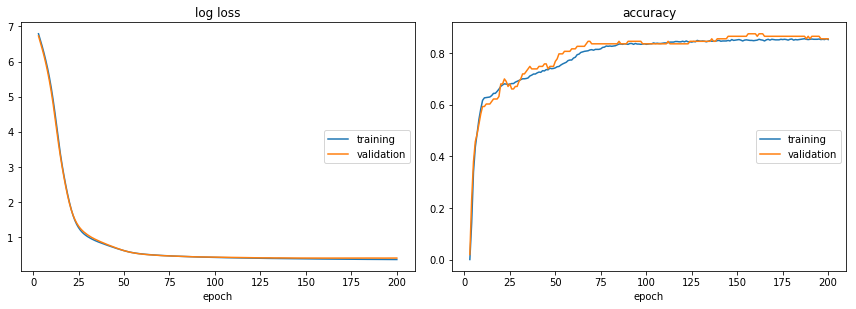

log loss:
training   (min:    0.359, max:    7.124, cur:    0.359)
validation (min:    0.399, max:    7.071, cur:    0.401)

accuracy:
training   (min:    0.000, max:    0.855, cur:    0.851)
validation (min:    0.000, max:    0.874, cur:    0.854)


In [33]:
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr )
device = 'cpu'

liveloss = PlotLosses()
for epoch in range(200):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [35]:
y_pred, y_gt = evaluate(model, test_loader)
correct = y_pred[y_pred==y_gt].shape[0]
count = y_pred.shape[0]
print(correct, correct/count)

777 0.7102376599634369


##### Fluid 

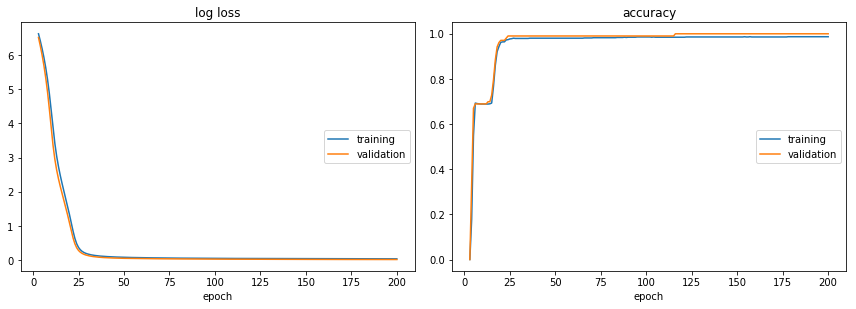

log loss:
training   (min:    0.037, max:    7.020, cur:    0.037)
validation (min:    0.017, max:    6.969, cur:    0.017)

accuracy:
training   (min:    0.000, max:    0.987, cur:    0.987)
validation (min:    0.000, max:    1.000, cur:    1.000)


In [36]:
Y = torch.Tensor(Y2)
Y = Y.long()

Y_2 = torch.Tensor(Y2_test)
Y_2 = Y_2.long()

X = torch.Tensor(X_o)
X_2 = torch.Tensor(X_test_o)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
X_test, Y_test = X_2, Y_2

data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)
data_test = TensorDataset(X_test, Y_test)

input_size = 9
num_classes = len(set(Y))
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(data_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr )
device = 'cpu'

liveloss = PlotLosses()
for epoch in range(200):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [37]:
y_pred, y_gt = evaluate(model, test_loader)
correct = y_pred[y_pred==y_gt].shape[0]
count = y_pred.shape[0]
print(correct, correct/count)

973 0.8893967093235832


##### MixLabel

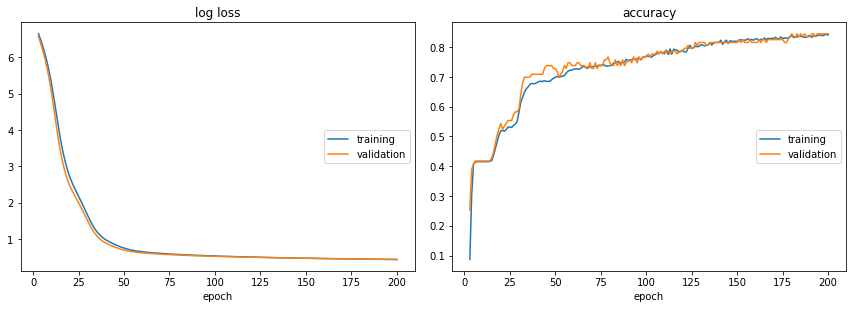

log loss:
training   (min:    0.439, max:    6.904, cur:    0.439)
validation (min:    0.441, max:    6.839, cur:    0.441)

accuracy:
training   (min:    0.000, max:    0.843, cur:    0.841)
validation (min:    0.000, max:    0.845, cur:    0.845)


In [38]:
Y = torch.Tensor(Y3)
Y = Y.long()

Y_2 = torch.Tensor(Y3_test)
Y_2 = Y_2.long()

X = torch.Tensor(X_o)
X_2 = torch.Tensor(X_test_o)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, Y_train = X[indices[0]], Y[indices[0]]
X_val, Y_val = X[indices[1]], Y[indices[1]]
X_test, Y_test = X_2, Y_2

data_train = TensorDataset(X_train, Y_train)
data_val = TensorDataset(X_val, Y_val)
data_test = TensorDataset(X_test, Y_test)

input_size = 9
num_classes = len(set(Y))
hidden_size = 15
epochs = 100
lr = 0.01
batch_size = 64
test_batch_size = 1000

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(data_val, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(data_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr )
device = 'cpu'

liveloss = PlotLosses()
for epoch in range(200):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [40]:
y_pred, y_gt = evaluate(model, test_loader)
correct = y_pred[y_pred==y_gt].shape[0]
count = y_pred.shape[0]
print(correct, correct/count)

784 0.716636197440585


### SVM

In [41]:
from sklearn.svm import SVC

In [42]:
for (seq, label) in enumerate(['Fluid', 'Log_Facies', 'MixLabel']):
    Y = ALL_Y[seq]
    Y_TEST = ALL_Y_TEST[seq]
    clf = SVC()
    clf.fit(X_o, Y)
    pred = clf.predict(X_test_o)
    correct = pred[pred==Y_TEST].shape[0]
    print("label: {} correct: {:.2f}".format(label, correct/pred.shape[0]), correct)

label: Fluid correct: 0.92 1005
label: Log_Facies correct: 0.72 784
label: MixLabel correct: 0.67 732
